In [62]:
import matplotlib.pyplot as plt;
import numpy as np;
import astropy as apy;
from planets import CandidateTable, PlanetTable;
from stars import StarTable;
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from scipy.stats import binom
from scipy.stats import rv_continuous
import h5py
#%matplotlib inline

In [63]:
# in scenarios where the quantity has its errorbars
# reported with it, useful to use this mask to get
# just the value
emsk = (slice(None), 0)

In [64]:
# load stellar data
star_table = StarTable(verbose=0)
f = h5py.File('stars.hdf5', 'r')
star_table.loadHdf5(f)
#star_table.loadTable('sup_stars.tbl')

Text(0.5, 1.0, '45180 Stars')

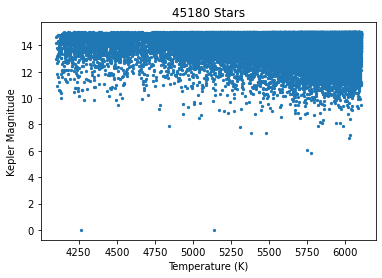

In [65]:
# make cuts
star_table.magCut()
star_table.loggCut()
star_table.tempCut()
temp = star_table.getMaskedData('temperature')
mag = star_table.getMaskedData('mag')
plt.scatter(temp[emsk], mag,s=5)
plt.ylabel('Kepler Magnitude')
plt.xlabel('Temperature (K)')
plt.title("%d Stars"%len(mag))

In [66]:
# load planetary data
pl_table = PlanetTable(verbose=1)
can_table = CandidateTable(verbose=1)

pl_table.loadTable('confirmed.tbl',load_other=["pl_orbsmax","st_rad"])
can_table.loadTable('candidate.tbl',load_other=["koi_sma","koi_srad"])

column headers from IPAC table:
['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility', 'soltype', 'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim', 'ttv_flag', 'st_refname', 'st_spectype', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1', 'st_raderr2', 'st_radlim', 'st_mass', 'st_masserr1', 'st_masserr2', 'st_masslim', 'st_met', 'st_meterr1', 'st_meterr2', 'st_metlim

In [67]:
can_table.magCut()
can_table.periodCut()
can_table.loggCut()
can_table.radiusCut(r_lim=(1,32))
can_table.tempCut()

pl_table.magCut()
pl_table.loggCut()
pl_table.tempCut()
pl_table.periodCut()
pl_table.radiusCut(r_lim=(1,32))

number of candidates before magnitude cut:
1952

number of candidates to fail magnitude cut:
747

number of candidates left:
1205

number of candidates before period cut:
1205

number of candidates to fail period cut:
680

number of candidates left:
746

number of candidates before log(g) cut:
746

number of candidates to fail log(g) cut:
297

number of candidates left:
596

number of candidates before planetary radius cut:
596

number of candidates to fail planetary radius cut:
379

number of candidates left:
356

number of candidates before effective temperature cut:
356

number of candidates to fail effective temperature cut:
547

number of candidates left:
217

number of planets before magnitude cut:
901

number of planets to fail magnitude cut:
2

number of planets left:
899

number of planets before log(g) cut:
899

number of planets to fail log(g) cut:
51

number of planets left:
850

number of planets before effective temperature cut:
850

number of planets to fail effective te

In [68]:
plan_p = pl_table.getMaskedData('period')
cand_p = can_table.getMaskedData('period')
plan_r = pl_table.getMaskedData('radius')
cand_r = can_table.getMaskedData('radius')

Text(0.5, 0, 'period (days)')

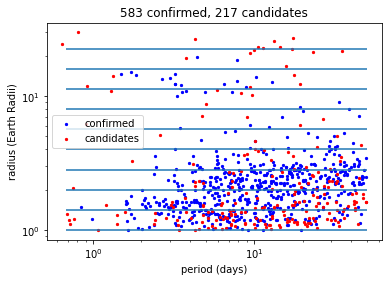

In [69]:
plt.scatter(plan_p[emsk], plan_r[emsk], color = 'blue', label = 'confirmed', s = 5)
plt.scatter(cand_p[emsk], cand_r[emsk], color = 'red', label = 'candidates', s = 5)
plt.hlines(radius_bins,xmin=0.68,xmax = 50.)
#plt.vlines(period_bins,ymin=1.6,ymax=23.)
plt.legend()
plt.loglog()
plt.title('%d confirmed, %d candidates'%(len(plan_p), len(cand_p)))
plt.ylabel('radius (Earth Radii)')
plt.xlabel('period (days)')

In [70]:
### organizing data for analysis
### need to get for each planet: semi-major axis, star radius, number of stars (fixed?),
nstars = len(mag)
sma_p = pl_table.getMaskedData('pl_orbsmax')[emsk] #semi major axis of the confirmed planets
str_p = pl_table.getMaskedData('st_rad')[emsk]     #star radius
rad_p = pl_table.getMaskedData('radius')[emsk]     #planet radius
per_p = pl_table.getMaskedData('period')[emsk]     #planet period
sma_c = can_table.getMaskedData('koi_sma')[emsk]   #etc for the candidates
str_c = can_table.getMaskedData('koi_srad')[emsk]
rad_c = can_table.getMaskedData('radius')[emsk]
per_c = can_table.getMaskedData('period')[emsk]
sma_p = np.append(sma_p,sma_c)                     #combine candidates with confirmed
str_p = np.append(str_p,str_c)
rad_p = np.append(rad_p,rad_c)
per_p = np.append(per_p,per_c)

In [97]:
#defining bins for planet radius
radius_bins = np.logspace(np.log10(1.),np.log10(32),num=11)
print(radius_bins)
rbinnage = np.digitize(rad_p,radius_bins)
print(rbinnage)

[ 1.          1.41421356  2.          2.82842712  4.          5.65685425
  8.         11.3137085  16.         22.627417   32.        ]
[ 1  1  2  6  1  4  4  2  2  4  2  4  4  5  3  2  3  2  3  3  1  1  3  2
  6  4  9  3  3  3  6  3  3  4  2  2  1  1  4  1  1  2  2  4  3  1  2  1
  2  2  4  2  1  2  4  3  3  4  1  1  4  2  3  2  4  5  7  1  4  3  4  4
  3  3  4  3  3  3  3  3  1  3  3  2  3  4  3  3  1  4  1  3  1  3  3  3
  3  5  3  3  2  2  1  1  1  1  3  8  4  4  3  3  2  3  4  3  3  1  3  2
  2  3  4  2  3  3  4  4  2  3  3  5  6  2  4  1  2  3  3  3  2  3  1  3
  2  4  1  3  2  2  1  2  3  3  2  3  3  2  2  3  1  1  1  3  3  4  2  4
  1  3  2  3  2  2  3  3  2  3  2  2  2  1  2  1  2  2  4  2  1  1  2  3
  4  4  4  1  1  1  3  2  3  2  2  3  3  4  2  4  4  4  3  2  1  2  4  3
  3  4  5  4  1  4  3  2  2  3  1  4  2  3  5  3  5  4  3  5  4  4  3  3
  1  3  3  1  3  2  3  4  3  3  3  2  3  1  3  3  3  3  3  3  2  3  3  3
  3  3  4  3  2  2  5  4  4  5  1  3  3  1  3  3  1  3  2  3  

In [98]:
#marginalize over radius, give me indices
rbin01 = np.argwhere(rbinnage == 1) #1 to 1.4
rbin02 = np.argwhere(rbinnage == 2) #1.4 to 2
rbin03 = np.argwhere(rbinnage == 3) #2 to 2.828
rbin04 = np.argwhere(rbinnage == 4) # to 4
rbin05 = np.argwhere(rbinnage == 5) # to 5.656854249
rbin06 = np.argwhere(rbinnage == 6) # to 8
rbin07 = np.argwhere(rbinnage == 7) # to 11.3
rbin08 = np.argwhere(rbinnage == 8) # to 16
rbin09 = np.argwhere(rbinnage == 9) # to 22.6
rbin10 = np.argwhere(rbinnage == 10)# to 32
rbins_all = [rbin01,rbin02,rbin03,rbin04,rbin05,rbin06,rbin07,rbin08,rbin09,rbin10]
rbins = [rbin03,rbin04,rbin05,rbin06,rbin07,rbin08,rbin09,rbin10]    #excludes radius < 2
#print(rbin09)
#print(type(plan_r[emsk][rbin09][0]))

In [99]:
#organizing the data to do the occurence rate over period
dat_wholeset = []
for i in range(len(rbins_all)):  #iterate over the bins
    indexs = rbins_all[i]
    dat_thisbin = []
    for j in range(len(indexs)):
        dat_thisbin.append(np.array([sma_p[indexs[j][0]],str_p[indexs[j][0]],rad_p[indexs[j][0]]],dtype=float))
    meanR = np.nanmean(rad_p[indexs])
    dat_wholeset.append((dat_thisbin,meanR))
xxx = np.array(dat_wholeset,dtype=object)
for i in xxx:
    print(len(i[0]))  #get the number of planets in each radius bin
#xxx hold relevant date for all planets
#xxx[i] specifies a radius bin
#xxx[i] has 2 components: tuple(semi major axis, star radius) and mean planet radius of the bin

209
202
214
88
27
11
13
19
9
8


In [123]:
def f_cell(onebin):
    #onebin should hold all planets in a bin
    #onebin[i] holds relevant parameters of planet i of cell dat: a, Rstar
    #onebin[i][j]
    #would also include number of stars associated with planet i, but alas
    #will sum over planets
    global nstars
    nplanets = len(onebin)
    pj = []
    for i in range(len(onebin)):
        pj.append(onebin[i][1] / onebin[i][0])
    pj = np.array(pj)
    expres = 1/pj / nstars
    ans = np.sum(expres)
    #error calculation
    if ans == 0.0:
        return ans, (0.,0.)
    nseff = nplanets / ans
    er_plan = np.sqrt(nplanets)
    er_star = np.sqrt(nseff)
    errd = nplanets / nseff * np.sqrt((er_plan/nplanets)**2 + (er_star/nseff)**2)
    err = (errd/2,errd/2)
    return ans, err
#
def n_nd(onebin):
    #onebin planet data
    #will call f_cell, needs: a, Rstar
    n_pl = len(onebin)
    f_c, errOnFC = f_cell(onebin)
    if f_c == 0.0:
        return "EmptyBin"
    else:
        return n_pl/f_c - n_pl
#
def likelihood(parameter_grid):
    #allbins hold data from all radius bins
    #allbins[i] holds data for radius bin i
    global xxx
    k_R, alph = parameter_grid
    expres = []
    for i in range(len(xxx)): #loop through all the bins
        r_bin, R_p = xxx[i]
        n_pl = len(r_bin)
        n_np = n_nd(r_bin)
        grida = np.ones((len(k_R),len(alph)),dtype=float)
        if n_np == "EmptyBin":    #if the bin is empty start the forloop again for the new bin
            expres.append(grida*-99.)
            continue
        aa = 1. - k_R * R_p**alph
        #will check k_R, R_p, and aa for friendliness with log
        badset = np.logical_or(aa <= 0, k_R <= 0.,dtype=bool)  #will run True if these cause a log problem
        #print(badset.shape)
        grida[badset] = -99.
        mask = np.invert(badset)
        grida[mask] = np.log(k_R[mask]) + alph[mask] * np.log(R_p)
        grida[mask] *= n_pl 
        grida[mask] += n_np * np.log(aa[mask])
        #print(grida.shape)
        expres.append(grida)
        pass
    hoot = np.array(expres,dtype=float)
    return np.nansum(hoot,axis=0)

In [137]:
## gonna calc occurence as function of radius
r_fcell = []
r_ferrr = []
for i in range(len(xxx)):
    binr, Rp = xxx[i]
    val, erd = f_cell(binr)
    r_fcell.append(val)
    r_ferrr.append(erd)
r_fcell = np.array(r_fcell,dtype=float)
r_ferrr = np.array(r_ferrr, dtype=float)
r_ferrr= r_ferrr.T

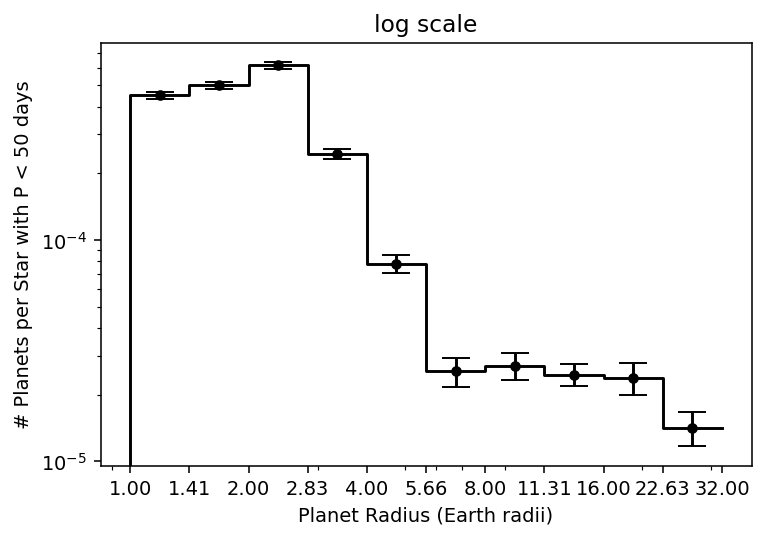

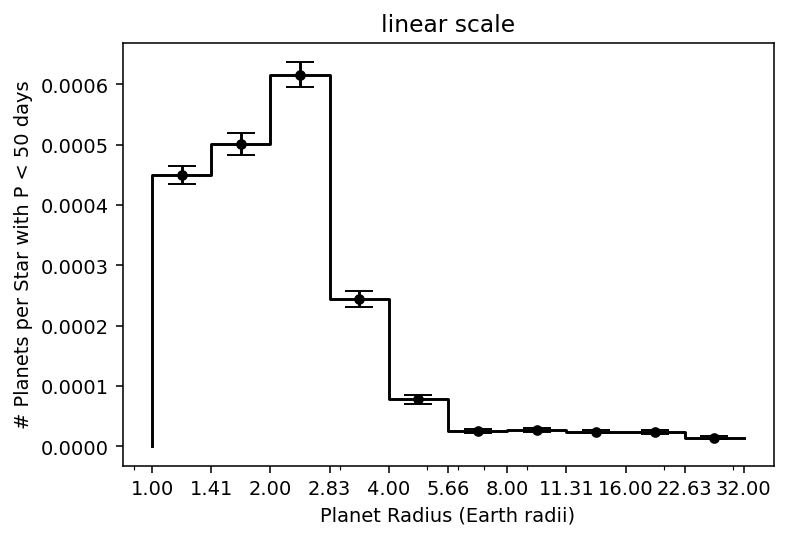

In [139]:
xb = radius_bins*2**0.25
### log-log plot ###
####################
fig1,ax1 = plt.subplots()
fig1.figsize = (8,4.5)
fig1.dpi = 140
#
ax1.scatter(xb[:-1],r_fcell,color='k',s=20)
(_, caps, _) = ax1.errorbar(xb[:-1],r_fcell,yerr=r_ferrr,fmt="none",color='k',capsize=7)
for cap in caps:
    cap.set_markeredgewidth(1)
ax1.step(radius_bins, np.append([0],r_fcell),c='k')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xticks(radius_bins)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_xlabel("Planet Radius (Earth radii)")
ax1.set_ylabel("# Planets per Star with P < 50 days")
ax1.set_title("log scale")
plt.show()
### log-linear plot ###
#######################
fig2,ax2 = plt.subplots()
fig2.figsize = (8,4.5)
fig2.dpi = 140
#
ax2.scatter(xb[:-1],r_fcell,color='k',s=20)
(_, caps, _) = ax2.errorbar(xb[:-1],r_fcell,yerr=r_ferrr,fmt="none",color='k',capsize=7)
for cap in caps:
    cap.set_markeredgewidth(1)

ax2.step(radius_bins, np.append([0],r_fcell),c='k')
ax2.set_xscale("log")
#ax2.set_yscale("log")
ax2.set_xticks(radius_bins)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.set_xlabel("Planet Radius (Earth radii)")
ax2.set_ylabel("# Planets per Star with P < 50 days")
ax2.set_title("linear scale")
plt.show()

In [ ]:
#k_R should stay positive
#alph should be a free spirit, no?
krs = np.linspace(0.1,5.,num=200)
als = np.linspace(-5.,-0.1,num=200)
gridd = np.meshgrid(krs,als)

#print(xxx)
door = likelihood(gridd)
#print(door)
#i promise, at one point this spit out actual numbers but no more

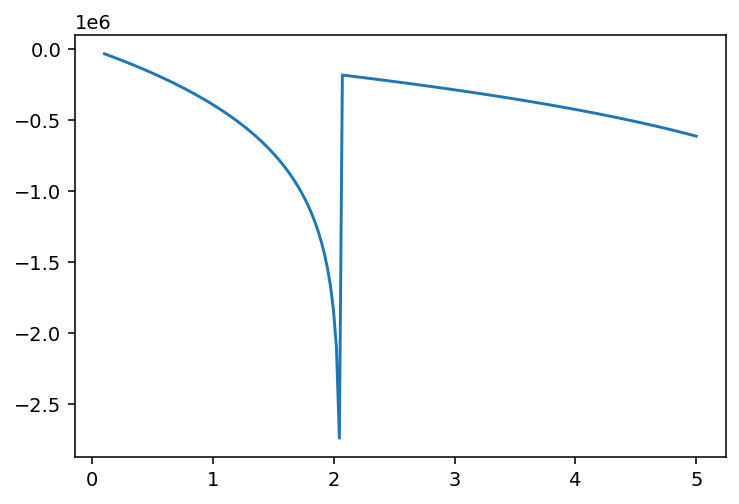

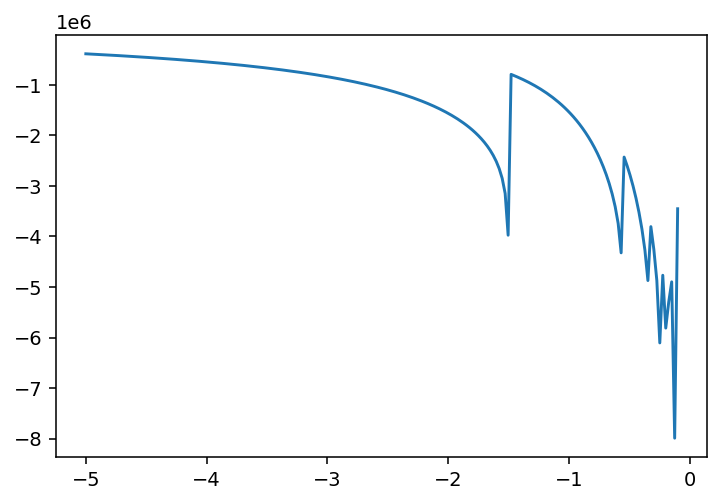

In [89]:
fig1,ax1 = plt.subplots()
fig1.figsize = (8,4.5)
fig1.dpi=140
#
ax1.plot(krs,door[50,:])

plt.show()
#
fig2,ax2 = plt.subplots()
fig2.figsize = (8,4.5)
fig2.dpi=140
ax2.plot(als,door[:,50])
plt.show()

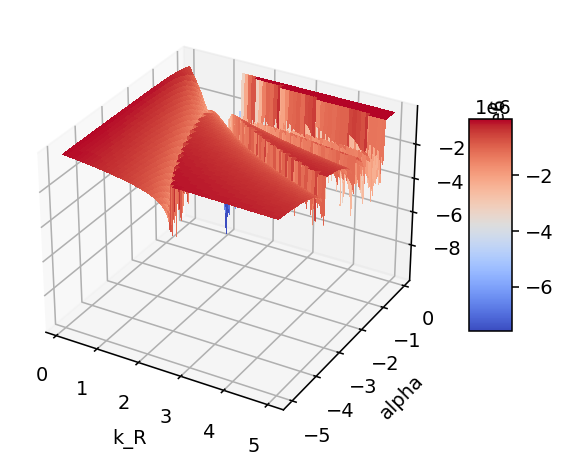

In [90]:
#copied most of this from the plot_surface() documentation
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.figsize = (8,4.5)
fig.dpi = 140
# Plot the surface.
surf = ax.plot_surface(gridd[0], gridd[1], door, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("k_R")
ax.set_ylabel("alpha")
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [36]:
### by orbital period
### separating planets by plantary radius
#rad_bins2 = np.logspace(np.log10(2),np.log10(8),num=3)
rbinnage2 = np.digitize(rad_p,[2,4,8,32])
#print(rbinnage2)
#
sbin01 = np.argwhere(rbinnage2 == 1)
sbin02 = np.argwhere(rbinnage2 == 2)
sbin03 = np.argwhere(rbinnage2 == 3)
#print(sbin01[0][0])
#
radius_set1 = [(sma_p[sbin01[i][0]], str_p[sbin01[i][0]], rad_p[sbin01[i][0]], per_p[sbin01[i][0]]) for i in range(len(sbin01))]
radius_set2 = [(sma_p[sbin02[i][0]], str_p[sbin02[i][0]], rad_p[sbin02[i][0]], per_p[sbin02[i][0]]) for i in range(len(sbin02))]
radius_set3 = [(sma_p[sbin03[i][0]], str_p[sbin03[i][0]], rad_p[sbin03[i][0]], per_p[sbin03[i][0]]) for i in range(len(sbin03))]
radius_set1 = np.array(radius_set1,dtype=object) #2-4 E-radii
radius_set2 = np.array(radius_set2,dtype=object) #4-8
radius_set3 = np.array(radius_set3,dtype=object) #8-32
#print(len(radius_set1),len(radius_set2),len(radius_set3))

period_bins = np.logspace(np.log10(0.683990378),np.log10(50),num=9)
#print(period_bins)
pbinnage = np.digitize(plan_p[emsk],period_bins)
print(pbinnage)
#
pbin01 = np.argwhere(pbinnage == 1)
pbin02 = np.argwhere(pbinnage == 2)
pbin03 = np.argwhere(pbinnage == 3)
pbin04 = np.argwhere(pbinnage == 4)
pbin05 = np.argwhere(pbinnage == 5)
pbin06 = np.argwhere(pbinnage == 6)
pbin07 = np.argwhere(pbinnage == 7)
pbin08 = np.argwhere(pbinnage == 8)
pbin09 = np.argwhere(pbinnage == 9)   #prob empty
pbins = [pbin01,pbin02,pbin03,pbin04,pbin05,pbin06,pbin07,pbin08,pbin09]

[4 6 7 6 6 7 8 8 8 5 7 5 7 3 4 3 8 4 6 7 8 7 7 8 6 4 8 6 7 8 8 4 7 4 5 6 8
 6 7 7 7 8 8 5 4 6 6 6 6 8 4 5 7 7 6 7 5 6 8 5 8 6 2 5 6 4 6 3 5 6 8 5 6 8
 6 7 5 7 5 6 8 4 6 6 7 7 5 7 5 7 7 5 8 7 8 7 6 5 7 3 4 6 5 6 8 3 5 8 4 8 5
 7 8 4 7 8 4 6 7 4 6 7 5 6 4 5 4 6 5 6 8 6 8 4 6 5 3 7 8 5 5 6 6 5 6 7 5 6
 8 5 4 4 5 7 5 7 8 4 5 7 5 6 5 7 6 8 6 6 7 4 6 7 5 3 4 6 3 5 7 6 8 5 8 8 5
 6 6 8 6 8 5 5 7 7 4 6 6 5 5 4 6 8 6 6 8 7 8 7 8 6 8 4 5 6 7 7 5 8 5 8 8 8
 3 4 5 6 5 7 8 5 6 6 8 5 4 4 6 5 8 6 4 6 8 6 7 8 8 5 5 7 6 7 8 5 7 7 5 7 8
 6 8 8 5 6 6 7 7 7 3 6 8 2 2 5 3 3 4 3 6 4 3 8 6 3 5 8 8 5 8 3 5 7 6 6 5 5
 5 4 5 5 5 7 8 7 8]


In [114]:
##orbital period analysis given a radius_set
def p_fcell(radset):
    #radset is a N,3 array where N in number of planets in the radius bin
    #
    global nstars
    global period_bins
    all_cells_f = []
    err = []
    for i in range(len(period_bins)-1):
        bindat = radset[np.logical_and(radset[:,3] >= period_bins[i], radset[:,3] < period_bins[i+1])]
        nplanets = len(bindat)
        pj = bindat[:,1] / bindat[:,1]
        expres = 1/pj/nstars
        ans = np.sum(expres)
        all_cells_f.append(ans)
        #error calculation
        if ans == 0.0:
            err.append((0,0))
            continue
        neffstars = nplanets / ans
        er_plan = np.sqrt(nplanets)
        er_star = np.sqrt(neffstars)
        errd = nplanets / neffstars * np.sqrt((er_plan/nplanets)**2 + (er_star/neffstars)**2)
        err.append((errd/2,errd/2))
    all_cells_f = np.array(all_cells_f,dtype=float)
    err = np.array(err,dtype=float)
    #err = err.T
    return all_cells_f, err

In [113]:
'''
en, pe = len(bindat)/ans, ans
#mean,var = binom.stats(en,pe,moments='mv')
xx = np.arange(binom.ppf(0.01,en,pe), binom.ppf(0.99,en,pe))
prob = binom.cdf(xx,en,pe)
e_lo = np.interp(0.159,prob,xx) / en
e_hi = np.interp(0.841,prob,xx) / en
'''

"\nen, pe = len(bindat)/ans, ans\n#mean,var = binom.stats(en,pe,moments='mv')\nxx = np.arange(binom.ppf(0.01,en,pe), binom.ppf(0.99,en,pe))\nprob = binom.cdf(xx,en,pe)\ne_lo = np.interp(0.159,prob,xx) / en\ne_hi = np.interp(0.841,prob,xx) / en\n"

68.0 67.98851150427691
0.00016894846651603076
0.00014723136015308279 0.00018817835990907436


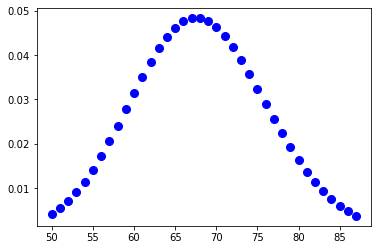

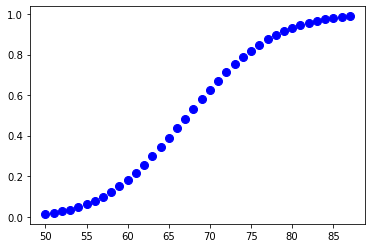

In [44]:
bind = radius_set1[np.logical_and(radius_set1[:,3] >= period_bins[5], radius_set1[:,3] < period_bins[6])]
#print(bind)
aa = bind[:,1] / bind[:,0]
bb = 1/aa/nstars
cc = np.sum(bb)
#print(len(bind),cc)
n,p=len(bind)/cc,cc
m, v = binom.stats(n,p,moments='mv')
print(m,v)
c1,c2 = binom.ppf(0.01, n, p), binom.ppf(0.99, n, p)
x = np.arange(c1,c2)
probs = binom.cdf(x,n,p)
el = np.interp(0.159,probs,x) / n
eh = np.interp(0.841,probs,x) / n
print(cc)
print(el,eh)
#print(c2-m,c1-m)
#print(x)
#
fig,ax = plt.subplots()
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
plt.show()

fig,ax = plt.subplots()
ax.plot(x, binom.cdf(x, n, p), 'bo', ms=8, label='binom cdf')
plt.show()

In [115]:
hey1,her1 = p_fcell(radius_set1)
hey2,her2 = p_fcell(radius_set2)
hey3,her3 = p_fcell(radius_set3)
#print(radius_set2)
print(hey2)
print(her1)

[2.21336875e-05 0.00000000e+00 4.42673749e-05 6.64010624e-05
 1.10668437e-04 1.99203187e-04 1.54935812e-04 2.43470562e-04]
[[1.10669662e-05 1.10669662e-05]
 [1.10669662e-05 1.10669662e-05]
 [3.32038379e-05 3.32038379e-05]
 [6.16387138e-05 6.16387138e-05]
 [8.72001851e-05 8.72001851e-05]
 [9.13281824e-05 9.13281824e-05]
 [8.92879062e-05 8.92879062e-05]
 [8.57803053e-05 8.57803053e-05]]


In [46]:
def cumu_rate(i, orates_period, errors_period):
    #i: the index of the period out to which you want the cumulative o rate
    #i = 0 will return 0 for now, might have to adjust
    #i = len(orates_period) will sum over all period bins
    #orates_period: array with occurence rates of planets with increasing periods
    ans = np.sum(orates_period[:i])
    err = np.sqrt(np.sum(errors_period[:i]**2,axis=0)) #adding errors in quad
    return ans, err

In [47]:
y1, y1_errs = p_fcell(radius_set1)
print(y1_errs[:4])
fork = np.sqrt(np.sum(y1_errs[:4]**2,axis = 0))
print(fork)

[[1.10669662e-05 1.10669662e-05]
 [1.10669662e-05 1.10669662e-05]
 [3.32038379e-05 3.32038379e-05]
 [6.16387138e-05 6.16387138e-05]]
[7.17410717e-05 7.17410717e-05]


In [128]:
print(y1_errs)
print(y2_errs)
print(y4_errs)

[[0.00000000e+00 3.47973374e-05]
 [0.00000000e+00 3.47973374e-05]
 [1.21198271e-04 2.55020597e-04]
 [5.52101997e-04 7.98016264e-04]
 [1.18708481e-03 1.53533117e-03]
 [1.31173993e-03 1.67628406e-03]
 [1.24931980e-03 1.60590051e-03]
 [1.14571173e-03 1.48816823e-03]]
[[0.00000000e+00 0.00000000e+00 1.93563731e-06 1.61854273e-05
  4.96855145e-05 1.21198271e-04 8.51450030e-05 1.58884290e-04]
 [3.47973374e-05 0.00000000e+00 6.44229079e-05 9.41836907e-05
  1.49502454e-04 2.55020597e-04 2.02473582e-04 3.05895364e-04]]
[[1.93563731e-06 4.96855145e-05 1.38834906e-04 5.61839742e-04
  1.19870064e-03 1.32007589e-03 1.25404625e-03 1.15678933e-03]
 [8.10679989e-05 1.53498659e-04 3.16333218e-04 8.35557241e-04
  1.57262988e-03 1.70761802e-03 1.62812557e-03 1.52219816e-03]]


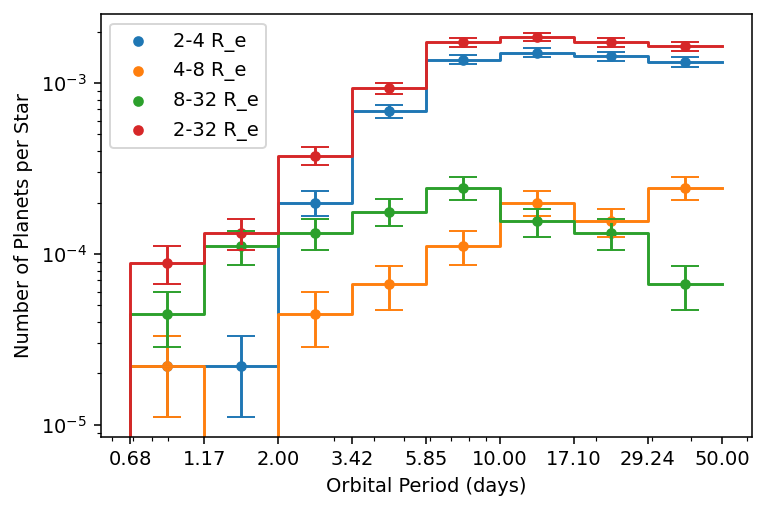

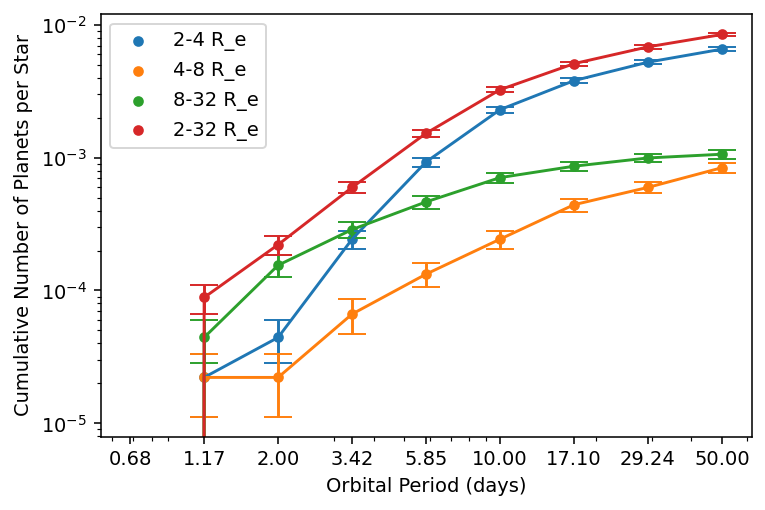

In [116]:
#plotting figure 6
y1, y1_errs = p_fcell(radius_set1)
y2, y2_errs = p_fcell(radius_set2)
y3, y3_errs = p_fcell(radius_set3)
y4 = y1+y2+y3
y4_errs = np.sqrt(y1_errs**2 + y2_errs**2 + y3_errs**2)
xa = period_bins[:-1]*1.307660486 #getting the midpoints of the bins (in log space)
# cumulative
t = np.arange(len(y1)+1)
z1 = []
z2 = []
z3 = []
z1e = []
z2e = []
z3e = []
#z_er = []
for i in t:
    z11, ze1 = cumu_rate(i,y1,y1_errs)
    z22, ze2 = cumu_rate(i,y2,y2_errs)
    z33, ze3 = cumu_rate(i,y3,y3_errs)
    z1.append(z11)
    z2.append(z22)
    z3.append(z33)
    z1e.append(ze1)
    z2e.append(ze2)
    z3e.append(ze3)
z1 = np.array(z1,dtype=float)
z2 = np.array(z2,dtype=float)
z3 = np.array(z3,dtype=float)
z1_errs = np.array(z1e,dtype=float).T
z2_errs = np.array(z2e,dtype=float).T
z3_errs = np.array(z3e,dtype=float).T
z4 = z1+z2+z3
z4_errs = np.sqrt(z1_errs**2 + z2_errs**2 + z3_errs**2)
y1_errs = y1_errs.T
y2_errs = y2_errs.T
y3_errs = y3_errs.T
y4_errs = y4_errs.T
#
fig,ax1 = plt.subplots()
fig.figsize=(8,4.5)
fig.dpi=140
#scatters
#gonna loop this
yss = [y1,y2,y3,y4]
yer = [y1_errs,y2_errs,y3_errs,y4_errs]
cls = ['C0','C1','C2','C3']
lbs = ['2-4 R_e','4-8 R_e','8-32 R_e','2-32 R_e']
for i in range(len(yss)):
    ax1.scatter(xa,yss[i],label=lbs[i],s=20)
    (_, caps, _) = ax1.errorbar(xa,yss[i],yerr=yer[i],fmt="none",color=cls[i],capsize=7)
    for cap in caps:
        cap.set_markeredgewidth(1)
    pass
#steps
ax1.step(period_bins, np.append([0],y1))
ax1.step(period_bins, np.append([0],y2))
ax1.step(period_bins, np.append([0],y3))
ax1.step(period_bins, np.append([0],y4))
#
ax1.legend(loc="best")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xticks(period_bins)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_xlabel("Orbital Period (days)")
ax1.set_ylabel("Number of Planets per Star")
plt.show()
##################################
# second plot bc adding another subplot does not work bc why would it haha (:
#
fig,ax2 = plt.subplots()
fig.figsize=(8,4.5)
fig.dpi=140
#scatters cumulative
zss = [z1,z2,z3,z4]
zer = [z1_errs,z2_errs,z3_errs,z4_errs]
for i in range(len(zss)):
    ax2.scatter(period_bins,zss[i],label=lbs[i],s=20)
    (_, caps, _) = ax2.errorbar(period_bins,zss[i],yerr=zer[i],fmt="none",color=cls[i],capsize=7)
    for cap in caps:
        cap.set_markeredgewidth(1)
    pass
'''
ax2.scatter(period_bins,z2,label="4-8 R_e",s=20)
ax2.scatter(period_bins,z3,label="8-32 R_e",s=20)
ax2.scatter(period_bins,z4,label="2-32 R_e",s=20)
'''
#lines cumulative
ax2.plot(period_bins, z1)
ax2.plot(period_bins, z2)
ax2.plot(period_bins, z3)
ax2.plot(period_bins, z4)
#
ax2.legend(loc="best")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xticks(period_bins)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.set_xlabel("Orbital Period (days)")
ax2.set_ylabel("Cumulative Number of Planets per Star")


plt.show()

In [50]:
def model_period(period, k_P, beta, P0, gamm):
    return k_P * period ** beta * (1 - np.exp( -(period/P0)**gamm ))
#pp = np.logspace(-1,2,num=40)
#print(pp)
#yy = model_period(pp,.064,0.27,7.0,2.6)
#plt.plot(pp,yy)
#plt.show

[[ 1.56776697e-03 -8.41657973e-01  6.06957073e+00  1.79747896e+00]
 [ 1.38929655e-03  3.05094489e-01  2.11349358e+00  2.38963296e-01]]
[ 1.56776697e-03 -8.41657973e-01  6.06957073e+00  1.79747896e+00]
[1.38929655e-03 3.05094489e-01 2.11349358e+00 2.38963296e-01]


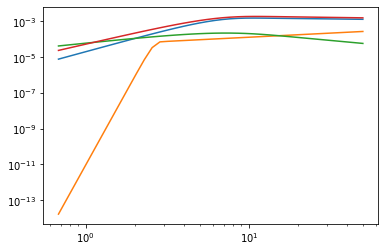

In [51]:
## fitting model to data
guess_parameters = [(0.064,0.27,7.0,2.6), (.0020,0.79,2.2,4.0), (.0025,0.37,1.7,4.1), (0.035,0.52,4.8,2.4)] #for 2-4, 4-8, 8-32
yss = [y1,y2,y3,y4]

bestfit = np.ones((2,4,4))  #fitvalue and error, four radius bins (3 bins plus 1 bin that is all the bins), 4 parameters
for i in range(len(guess_parameters)):
    paras, covar = curve_fit(model_period,xa,yss[i],p0 = guess_parameters[i])
    errs = np.sqrt(np.diag(covar))
    bestfit[0,i] = paras.copy()
    bestfit[1,i] = errs.copy()
    #print(type(paras))
    pp = np.logspace(np.log10(0.68),np.log10(50),num=40)
    yy = model_period(pp,paras[0],paras[1],paras[2],paras[3])
    plt.plot(pp,yy)
    plt.xscale("log")
    plt.yscale("log")
    plt.show
print(bestfit[:,2])

paras, covar = curve_fit(model_period,xa,yss[2],p0 = guess_parameters[2])
errs = np.sqrt(np.diag(covar))
print(paras)
print(errs)

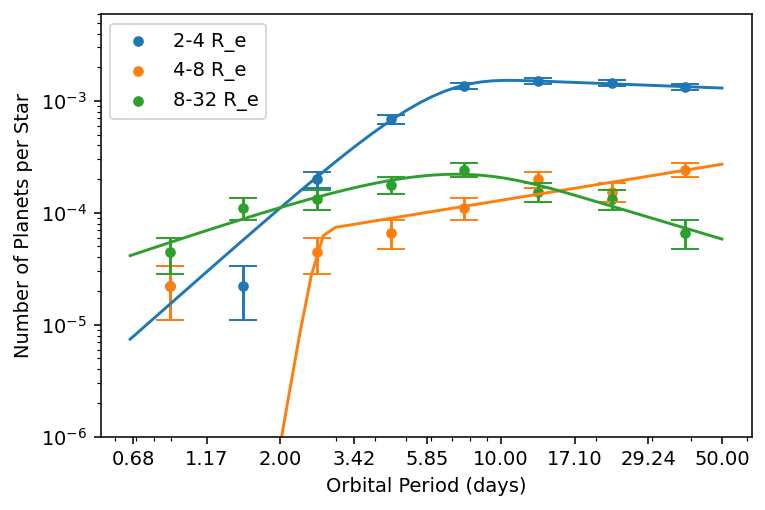

In [55]:
## plotting up figure 7
xt = np.logspace(np.log10(0.67),np.log10(50),num=50)

fig,ax1 = plt.subplots()
fig.figsize=(8,4.5)
fig.dpi=140
#scatters
yss = [y1,y2,y3,y4]
yer = [y1_errs,y2_errs,y3_errs,y4_errs]
cls = ['C0','C1','C2','C3']
lbs = ['2-4 R_e','4-8 R_e','8-32 R_e','2-32 R_e']
for i in range(len(yss)-1):
    ax1.scatter(xa,yss[i],label=lbs[i],s=20)
    (_, caps, _) = ax1.errorbar(xa,yss[i],yerr=yer[i],fmt="none",color=cls[i],capsize=7)
    for cap in caps:
        cap.set_markeredgewidth(1)
    pass
#ax1.scatter(xa,y1,label="2-4 R_e",s=20)
#ax1.scatter(xa,y2,label="4-8 R_e",s=20)
#ax1.scatter(xa,y3,label="8-32 R_e",s=20)
#ax1.scatter(xa,y4,label="2-32 R_e",s=20)
#model
ax1.plot(xt,model_period(xt,bestfit[0,0,0],bestfit[0,0,1],bestfit[0,0,2],bestfit[0,0,3]))
ax1.plot(xt,model_period(xt,bestfit[0,1,0],bestfit[0,1,1],bestfit[0,1,2],bestfit[0,1,3]))
ax1.plot(xt,model_period(xt,bestfit[0,2,0],bestfit[0,2,1],bestfit[0,2,2],bestfit[0,2,3]))
#ax1.plot(xa,model_period(xa,bestfit[0,3,0],bestfit[0,3,1],bestfit[0,3,2],bestfit[0,3,3]))
'''
ax1.step(period_bins, np.append([0],y1))
ax1.step(period_bins, np.append([0],y2))
ax1.step(period_bins, np.append([0],y3))
ax1.step(period_bins, np.append([0],y4))
'''
#
ax1.legend(loc="best")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xticks(period_bins)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_ylim((1e-6,6e-3))
ax1.set_xlabel("Orbital Period (days)")
ax1.set_ylabel("Number of Planets per Star")
plt.show()